## 掛載雲端硬碟


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 更改檔案所在路徑

In [ ]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning

/content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning


## Import library

In [ ]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [ ]:
!pip install thop
!pip install torchsummary

In [ ]:
from thop import profile
from torchsummary import summary

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 328947712.0
Params: 23513162.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [ ]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4 #要測試0 1e-5 1e-4去看結果

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000

EPOCHS = 40
LEARNING_RATE = 1e-3

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = '/content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning/model_best.pth' # Change to your own folder !!!

In [ ]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [ ]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s]


## 定義模型與設定Optimizer & CrossEntropy Loss


In [ ]:
model = ResNet50(num_classes=10)
if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 使用論文中稀疏化的方式更新參數(請填空)

In [ ]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
          m.weight.grad.data.add_(LAMBDA * m.weight.data.sign()) #在原本的Cross Entropy,加上Sparsity Regularization Loss

          #以下記錄一下這些分別在做什麼(上網查到可以這麼完成，來做一下筆記紀錄一下)
          # m.weight 部分是"scale",即gamma
          # 因為要完成演算法是需要"Classification Loss"的Gradient再加上Sparsity Regularization Loss
          # 其中，Sparsity Regularization Loss是使用L1-norm 是對gamma取絕對值
          # 對一個絕對值函數做微分會剛好是sign function -> .data.sign()
          # 所以最後使用 LAMBDA * m.weight.data.sign() 來完成論文中提到的方式


## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [ ]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

def train(epoch):
    model.train()
    correct = 0 #for train acc
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]

        total += target.size(0)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_acc_ratio = correct / float(total) #計算train acc
    print(f'Epoch: {epoch} Train Accuracy: {100. * train_acc_ratio:.2f}%')
    return train_acc_ratio

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)

          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item() * data.size(0)

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

##########################################################################################

best_prec1 = 0.
train_accuracies = [] #the list to store the train acc
test_accuracies = [] #the list to store the test acc
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    train_acc = train(epoch) # receive the train() acc
    prec1 = test()

    train_accuracies.append(train_acc)#then store the acc into list
    test_accuracies.append(prec1)#also store into list

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.629306
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.843793
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.576887
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.800665
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.526299
Epoch: 0 Train Accuracy: 36.97%

Test set: Average loss: 1.5103, Accuracy: 4664/10000 (46.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.295717
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.353768
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.445553
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.241588
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.225833
Epoch: 1 Train Accuracy: 53.92%

Test set: Average loss: 1.1581, Accuracy: 5927/10000 (59.3%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.104735
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 1.177224
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 1.132251
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 1.097084
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.965006
Epoch: 2 Train Accuracy: 61.91%

Test set: Av

## 繪製Sparsity-Training結果圖

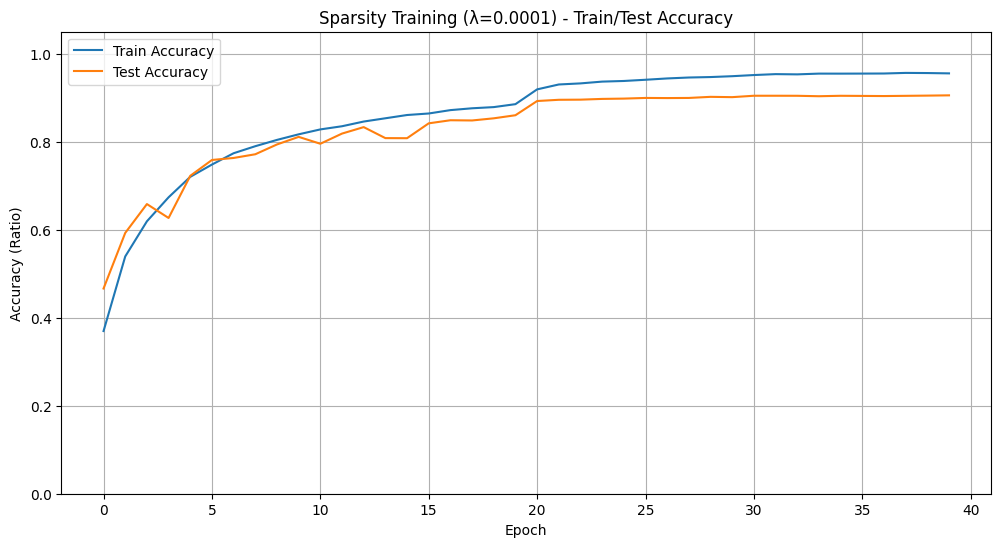

In [ ]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(START_EPOCH, EPOCHS), train_accuracies, label='Train Accuracy')
plt.plot(range(START_EPOCH, EPOCHS), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Ratio)') # 從 'Accuracy (%)' 改為 'Accuracy (Ratio)'
plt.title(f'Sparsity Training (λ={LAMBDA}) - Train/Test Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

## 繪製scaling factor 分布圖

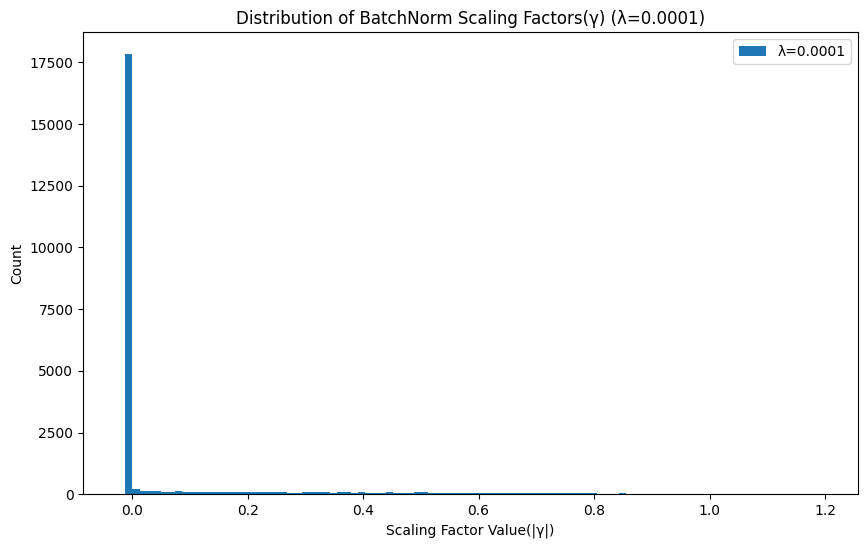

Total number of scaling factors (gammas): 22720


In [ ]:
#繪製 scaling factor 分布圖

# 收集所有 BN 層的 gamma (weight)
gammas = []
model.eval() # 確保模型在評估模式

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        # .data.clone().cpu().numpy() 確保我們得到的是 numpy 陣列且不影響梯度
        gammas.extend(m.weight.data.clone().cpu().numpy())

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(gammas, bins=100, label=f'λ={LAMBDA}')
plt.title(f'Distribution of BatchNorm Scaling Factors(γ) (λ={LAMBDA})')
plt.xlabel('Scaling Factor Value(|γ|)')
plt.ylabel('Count')
plt.legend()
plt.show()

print(f"Total number of scaling factors (gammas): {len(gammas)}")